In [1]:
%store -r __import

In [2]:
__import

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [11]:
def impute_median_sex_age_fare(df):
    male_passangers = df[df['Sex'] == 'male']
    female_passangers = df[df['Sex'] == 'female']
    male_passangers.Age.fillna(male_passangers.Age.median(), inplace=True)
    female_passangers.Age.fillna(female_passangers.Age.median(), inplace=True)
    new_df = pd.concat([male_passangers, female_passangers])
    new_df.Fare.fillna(new_df.Fare.median(), inplace=True)
    return new_df.sample(frac=1, random_state=42)

def impute_mode_embarked(df):
    print(df.Embarked.mode())
    df.Embarked.fillna('S', inplace=True)
    return df
    
def create_new_features(df):
    df['isincabin'] = df['Cabin'].notna().astype('int')
    df['is_underage'] = (df.Age < 18).astype('int')
    df['is_midlife'] = ((df.Age > 18) & (df.Age < 60)).astype('int')
    df['is_elder'] = (df.Age > 60).astype('int')
    df = pd.concat([df, pd.get_dummies(df.Sex)], axis=1)
    df = pd.concat([df, pd.get_dummies(df.Embarked)], axis=1)
    df = pd.concat([df, pd.get_dummies(df.Pclass)], axis=1)
    df.drop(['Sex'], axis=1, inplace=True)
    df.drop(['Embarked'], axis=1, inplace=True)
    df.drop(['Pclass'], axis=1, inplace=True)
    return df

In [4]:
train = pd.read_csv('/home/tuts/datasets/titanic/train.csv')
test = pd.read_csv('/home/tuts/datasets/titanic/test.csv')

In [5]:
print(f'Train shape {train.shape}')
print(f'Test shape {test.shape}')

Train shape (891, 12)
Test shape (418, 11)


In [6]:
train_test = pd.concat([train, test])

In [7]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


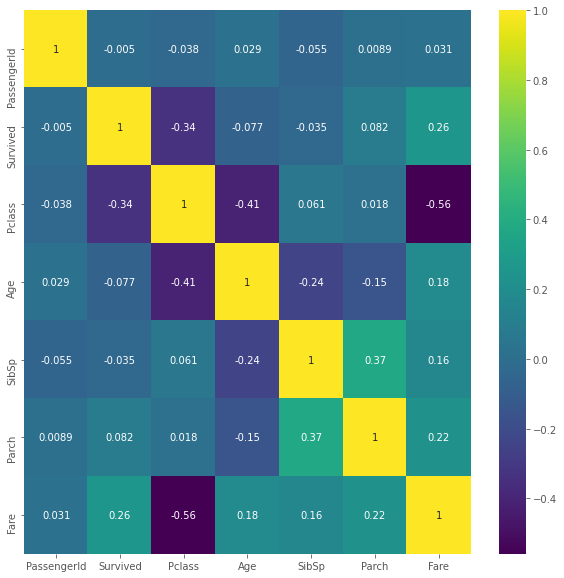

In [8]:
corr = train_test.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='viridis');

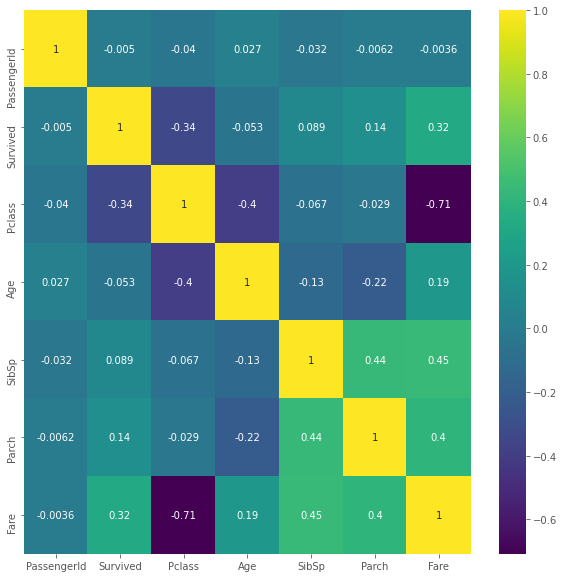

In [9]:
corr = train_test.corr(method='spearman')
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='viridis');

In [10]:
train_test.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [32]:
train_test[train_test['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,name_len,ticket_len,price_len
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,16,6,6
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,28,6,4
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,23,4,5
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,23,4,5
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,29,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q,31,6,6
410,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q,22,6,4
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,18,9,4
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,19,6,4


In [31]:
train_test['name_len'] = train_test.Name.apply(lambda x: len(x))
train_test['ticket_len'] = train_test.Ticket.apply(lambda x: len(x))
train_test['price_len'] = train_test.Fare.astype('str').apply(lambda x: len(x))

In [60]:
female_passangers = train[train['Sex']=='female']
female_passangers

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


In [12]:
female_passangers.Sex.value_counts()

female    314
Name: Sex, dtype: int64

In [13]:
female_passangers.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             53
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          217
Embarked         2
dtype: int64

In [14]:
female_passangers.Age.describe()

count    261.000000
mean      27.915709
std       14.110146
min        0.750000
25%       18.000000
50%       27.000000
75%       37.000000
max       63.000000
Name: Age, dtype: float64

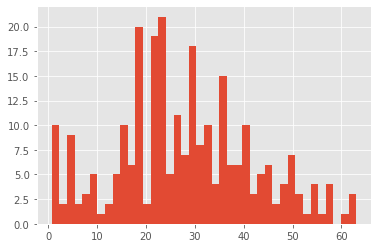

In [15]:
plt.hist(female_passangers.Age, bins=40);

In [16]:
female_passangers.Age.mode()

0    24.0
dtype: float64

In [17]:
female_passangers.Age.fillna(female_passangers.Age.median(), inplace=True)
female_passangers.isna().sum()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          217
Embarked         2
dtype: int64

In [18]:
male_passangers = train[train['Sex'] == 'male']
male_passangers

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [19]:
male_passangers.Age.describe()

count    453.000000
mean      30.726645
std       14.678201
min        0.420000
25%       21.000000
50%       29.000000
75%       39.000000
max       80.000000
Name: Age, dtype: float64

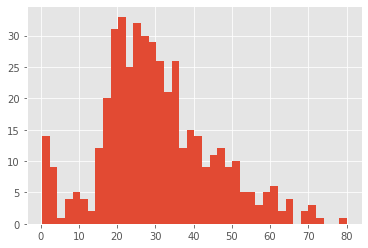

In [20]:
plt.hist(male_passangers.Age, bins=40);

In [21]:
male_passangers.Age.mode()

0    19.0
1    25.0
2    28.0
dtype: float64

In [22]:
male_passangers.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            124
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          470
Embarked         0
dtype: int64

In [23]:
male_passangers.Age.fillna(male_passangers.Age.median(), inplace=True)
male_passangers.isna().sum()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          470
Embarked         0
dtype: int64

In [19]:
t = train_test[['Survived', 'Fare']].groupby(['Survived'], as_index=False).median()
t

,Survived,Fare
0,0.0,10.5
1,1.0,26.0
